## Image classifier for the SVHN dataset
In this notebook, we will create a neural network that classifies real-world images digits.


We'll start by running some imports, and loading the dataset.

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd
from PIL import Image
from numpy import asarray
from matplotlib import image
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

For the  project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, we will have two files: `train_32x32.mat` and `test_32x32.mat`.

Our goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
### Downloading the dataset directly to the colab session

!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat


--2021-02-06 20:07:24--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  70.4MB/s    in 2.5s    

2021-02-06 20:07:26 (70.4 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2021-02-06 20:07:27--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  51.3MB/s    in 1.2s    

2021-02-06 20:07:28 (51.3 MB/s) - ‘test_32x32.mat.1’ saved [642

In [ ]:
# Load the dataset from our Drive folder
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset


In [ ]:
### different methods to preprocess the dataset

def split_data(train, test):
  X_train,Y_train = train['X'],train['y']
  X_test,Y_test = test['X'],test['y']
  X_train = np.moveaxis(X_train, -1, 0)
  X_test = np.moveaxis(X_test, -1, 0)
  return X_train,Y_train,X_test,Y_test

def tograyscale(X_train,X_test):
  X_train = np.mean(X_train, 3)
  X_test = np.mean(X_test,3)
  return X_train,X_test

def normalize(X_train,X_test):
  X_train = X_train /255.
  X_test = X_test /255.
  return X_train,X_test
  
def to_category(Y_train,Y_test):
  enc = OneHotEncoder().fit(Y_train)
  Y_train = enc.transform(Y_train).toarray()
  Y_test = enc.transform(Y_test).toarray()
  return Y_train,Y_test

In [ ]:
X_train,Y_train,X_test,Y_test = split_data(train, test)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(73257, 32, 32, 3) (73257, 1)
(26032, 32, 32, 3) (26032, 1)


[7]


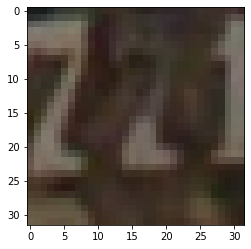

[3]


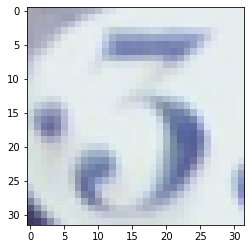

[2]


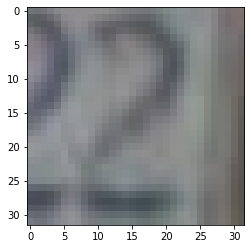

[5]


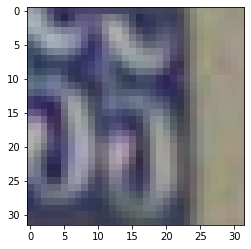

[9]


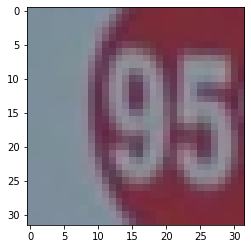

[3]


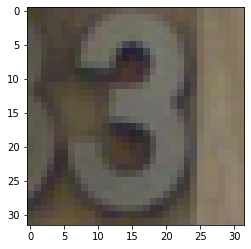

[2]


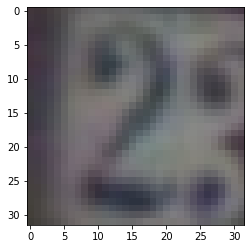

[2]


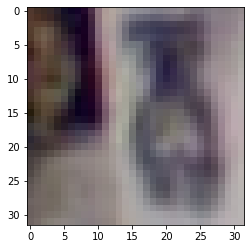

[6]


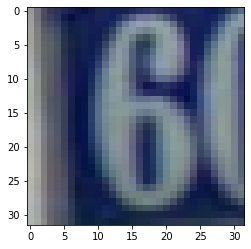

[1]


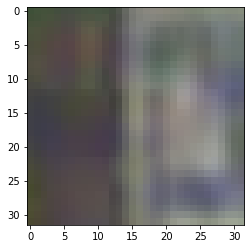

In [ ]:
import random
for i in range(10):
  n = random.randint(1,50000)
  image2 = Image.fromarray(X_train[n])
  print(Y_train[n])
  plt.imshow(image2)
  plt.show()

In [ ]:
X_train,X_test = tograyscale(X_train,X_test)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(73257, 32, 32) (73257, 1)
(26032, 32, 32) (26032, 1)


[8]


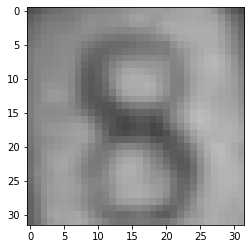

[4]


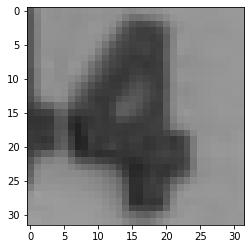

[2]


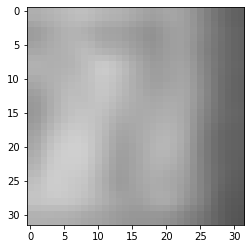

[5]


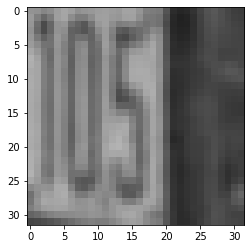

[10]


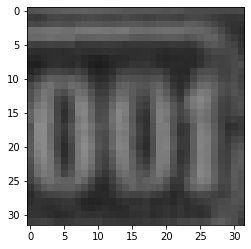

[9]


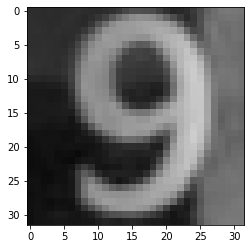

[4]


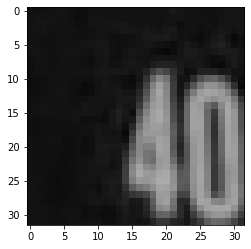

[2]


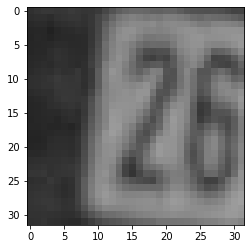

[5]


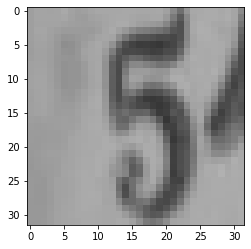

[9]


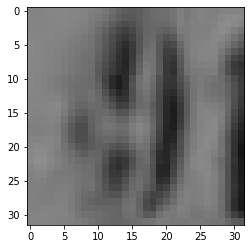

In [ ]:
import random
for i in range(10):
  n = random.randint(1,50000)
  print(Y_train[n])
  plt.imshow(Image.fromarray(X_train[n]))
  plt.show()

In [ ]:
#X_train,X_test = normalize(X_train,X_test)
y_train,y_test = to_category(Y_train,Y_test)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Our model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* Print out the model summary 
* Compile and train the model
* Aim to achieve a final categorical cross entropy training loss of less than 1.0
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
model_mlp = Sequential([
  layers.Flatten(input_shape = (32,32)),
  layers.Dense(128*2, activation='relu'),
  layers.Dense(64*2, activation='relu'),
  layers.Dense(32*2, activation='relu'),
  layers.Dense(10,activation='softmax')
])

model_mlp.compile(optimizer='adam',loss= 'categorical_crossentropy',metrics=['accuracy'])
model_mlp.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##  Saving the model weights
model_checkpoint= ModelCheckpoint(filepath="./checkpoint/model_{epoch:03d}", save_weights_only=True,
                                  monitor='val_accuracy', mode='max', save_best_only=False)

##  Saving the best model weights
best_model_checkpoint = ModelCheckpoint(filepath = './checkpoint/best_model',frequency='epoch',
                                        save_best_only=True,monitor='val_accuracy',save_weights_only=True, verbose=1)
## ReduceLROnPlateau CallBack
reduce_LROnPlateau= ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=True,patience=2)



In [ ]:
epochs=20
history = model_mlp.fit(X_train,y_train,epochs = epochs,validation_data=(X_test,y_test),
                    callbacks=[model_checkpoint,best_model_checkpoint,reduce_LROnPlateau])

Epoch 1/20
2290/2290 [==============================] - 8s 3ms/step - loss: 11.0183 - accuracy: 0.1493 - val_loss: 1.7828 - val_accuracy: 0.4122

Epoch 00001: val_accuracy improved from -inf to 0.41219, saving model to ./checkpoint/best_model
Epoch 2/20
2290/2290 [==============================] - 7s 3ms/step - loss: 1.6428 - accuracy: 0.4501 - val_loss: 2.0335 - val_accuracy: 0.4055

Epoch 00002: val_accuracy did not improve from 0.41219
Epoch 3/20
2290/2290 [==============================] - 7s 3ms/step - loss: 1.4209 - accuracy: 0.5451 - val_loss: 1.5550 - val_accuracy: 0.5235

Epoch 00003: val_accuracy improved from 0.41219 to 0.52351, saving model to ./checkpoint/best_model
Epoch 4/20
2290/2290 [==============================] - 7s 3ms/step - loss: 1.3169 - accuracy: 0.5821 - val_loss: 1.3571 - val_accuracy: 0.5757

Epoch 00004: val_accuracy improved from 0.52351 to 0.57571, saving model to ./checkpoint/best_model
Epoch 5/20
2290/2290 [==============================] - 7s 3ms/step

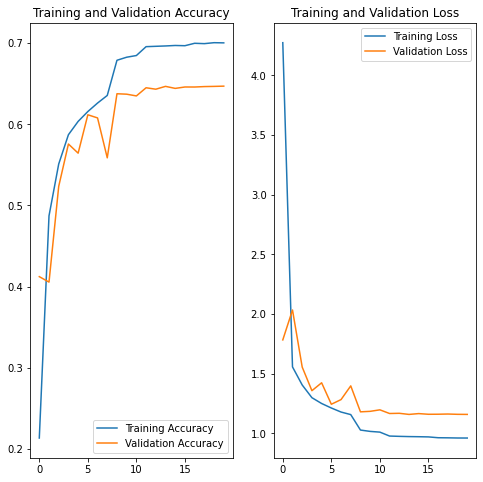

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should have a 10-way softmax output. 


In [ ]:
model_cnn = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(32,32,1)),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.15),
  layers.Dense(10,activation='softmax')
])

model_cnn.compile(optimizer='adam',loss= 'categorical_crossentropy',metrics=['accuracy'])
model_cnn.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 2048)            

In [ ]:
model_checkpoint= ModelCheckpoint(filepath="./checkpointCNN/model_{epoch:03d}",save_weights_only=True,
                                  monitor='val_accuracy',mode='max',save_best_only=False)

best_model_checkpoint = ModelCheckpoint(filepath = './checkpointCNN/best_model',frequency='epoch',save_best_only=True,
                                        monitor='val_accuracy',save_weights_only=True, verbose=1)
## ReduceLROnPlateau CallBack
reduce_LROnPlateau= ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=True,patience=2)

In [ ]:
epochs=10
history = model_cnn.fit(X_train[...,np.newaxis],y_train,epochs=epochs,validation_data=(X_test[...,np.newaxis],y_test),
                    callbacks=[model_checkpoint,best_model_checkpoint,reduce_LROnPlateau])

Epoch 1/10
2290/2290 [==============================] - 10s 4ms/step - loss: 1.2369 - accuracy: 0.5797 - val_loss: 0.5045 - val_accuracy: 0.8492

Epoch 00001: val_accuracy improved from -inf to 0.84922, saving model to ./checkpointCNN/best_model
Epoch 2/10
2290/2290 [==============================] - 9s 4ms/step - loss: 0.4934 - accuracy: 0.8481 - val_loss: 0.4421 - val_accuracy: 0.8716

Epoch 00002: val_accuracy improved from 0.84922 to 0.87158, saving model to ./checkpointCNN/best_model
Epoch 3/10
2290/2290 [==============================] - 9s 4ms/step - loss: 0.4093 - accuracy: 0.8747 - val_loss: 0.4869 - val_accuracy: 0.8538

Epoch 00003: val_accuracy did not improve from 0.87158
Epoch 4/10
2290/2290 [==============================] - 9s 4ms/step - loss: 0.3729 - accuracy: 0.8859 - val_loss: 0.4076 - val_accuracy: 0.8805

Epoch 00004: val_accuracy improved from 0.87158 to 0.88045, saving model to ./checkpointCNN/best_model
Epoch 5/10
2290/2290 [==============================] - 9s

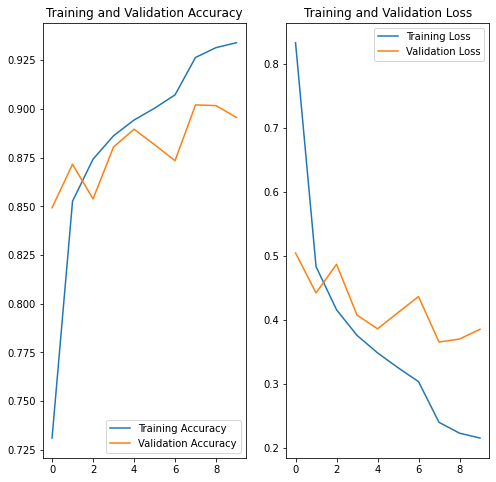

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)#

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. Get model predictions


In [ ]:
model_mlp.load_weights("/content/checkpoint/best_model")
model_cnn.load_weights("/content/checkpointCNN/best_model")

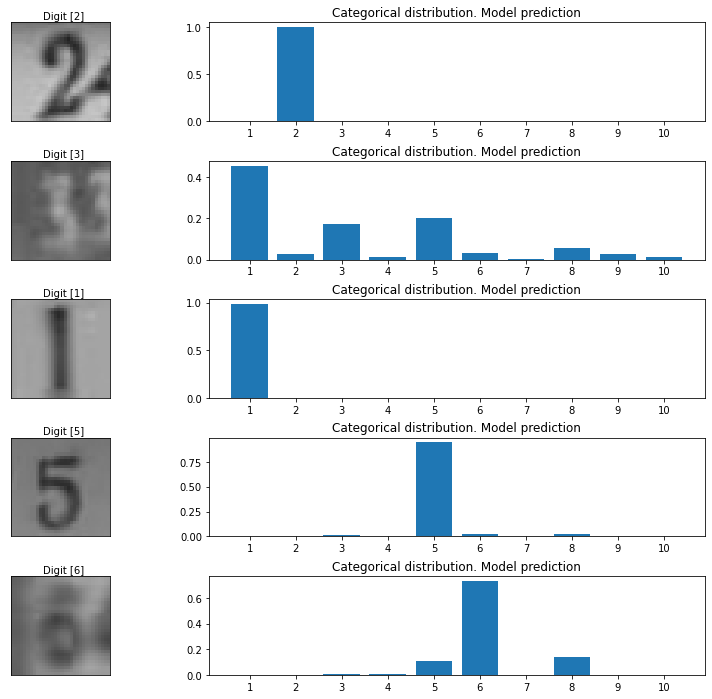

In [ ]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = Y_test[random_inx, ...]

predictions = model_mlp.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(Image.fromarray( image)) ##################
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()
  

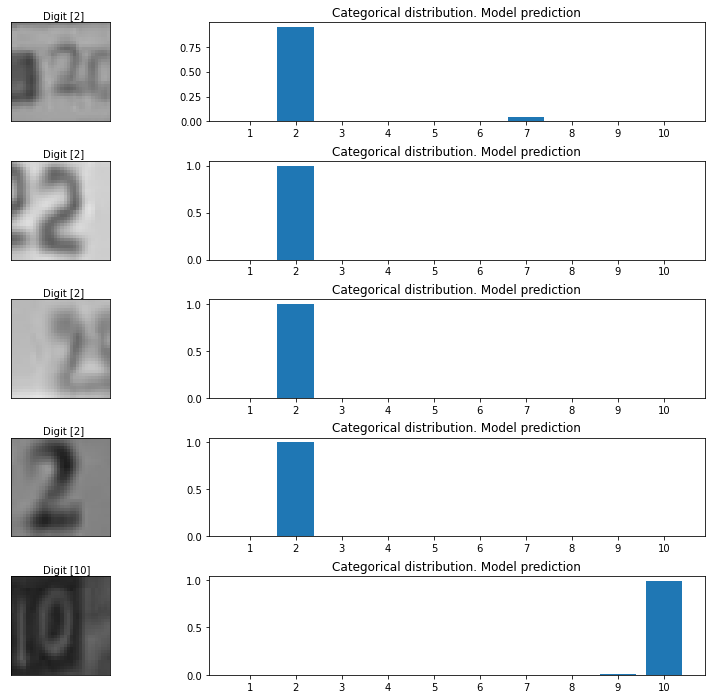

In [ ]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = Y_test[random_inx, ...]

predictions = model_cnn.predict(random_test_images[...,np.newaxis])

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(Image.fromarray( image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()